In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import astropy.units as u
import astropy.constants as const
from astropy.io import ascii, fits
from astropy.coordinates import SkyCoord
from astropy.table import Table
from astropy.modeling.models import BlackBody
from scipy import stats, interpolate
import astrotools.interpolate_stellar_spectra as interpspec
import pysynphot
import pickle
import json
import copy
import os
import glob
from collections import OrderedDict
import batman

from jwst_backgrounds import jbt
import pandeia.engine
from pandeia.engine.calc_utils import build_default_calc
from pandeia.engine.instrument_factory import InstrumentFactory
from pandeia.engine.perform_calculation import perform_calculation


print("Pandeia engine versions:", pandeia.engine.pandeia_version())

Pandeia Engine version:  3.1
Pandeia RefData version:  3.0
Synphot Data:  /home/hannah/programs/grp/redcat/trds
Pandeia engine versions: None


## Some initial settings

In [3]:
pull_default_dict = True # needs to be true if you want to pull a new default dictionary from pandeia
make_new_bkg      = True # should be true if working with different stars; otherwise set to False for speed
miri_arrays_descending = ['full', 'brightsky', 'sub256', 'sub128', 'sub64']

## Functions to interact with pandeia-engine

In [4]:
def get_bkg(targ, ref_wave, make_new_bkg=False, savepath='../sample/background/', verbose=False):
    """
    Code to retrieve sky background from the jwst backgrounds database based on system coordinates
    JWST backgrounds: https://jwst-docs.stsci.edu/jwst-general-support/jwst-background-model
    
    Inputs:
    targ          -- dictionary of target; must include RA and Dec of system as strings
    ref_wave      -- reference wavelength for jbt to return 
    make_new_bkg  -- default=True; otherwise you can load up the last background called, 
                                   use if only working with one system
                                   
    Returns:
    background    -- list of two lists containing wavelength (um) and background counts (mJy/sr)
    """
    
    print('Computing background')

    sys_coords = targ['rastr']+' '+targ['decstr']
    sys_name   = targ['hostname'].replace(" ", "")

    def bkg():
    
        # make astropy coordinates object
        c = SkyCoord(sys_coords, unit=(u.hourangle, u.deg))

        # use jwst backgrounds to compute background at this point
        bg = jbt.background(c.ra.deg, c.dec.deg, ref_wave)

        # background is computed for many days; choose one
        ndays = bg.bkg_data['calendar'].size
        assert ndays > 0  # make sure object is visible at some point in the year; if not check coords
        middleday = bg.bkg_data['calendar'][int(ndays / 2)] # picking the middle visible date; somewhat arbitrary!
        middleday_indx = np.argwhere(bg.bkg_data['calendar'] == middleday)[0][0]

        tot_bkg = bg.bkg_data['total_bg'][middleday_indx]
        wav_bkg = bg.bkg_data['wave_array']

        # background is [wavelength, total_background] in [micron, mJy/sr]
        background = [list(np.array(wav_bkg)), list(np.array(tot_bkg))]

        ascii.write(background, savepath+f"{sys_name}_background.txt", overwrite=True)
        
        print('Returning background')
        return background
    
    if make_new_bkg: background = bkg()

    else: 
        try: 
            print('Using existing background')
            background = ascii.read(savepath+f"{sys_name}_background.txt")
            background = [list(background['col0']), list(background['col1'])]
        except:
            background = bkg()
    
    return background

In [5]:
def make_miri_dict(filter, subarray, targ, pull_default_dict=False, scene_spec='phoenix', key='m5v', input_spec=[], savepath='./', verbose=False):
    """
    Code to make the initial miri dictionally for imaging_ts
    
    Inputs:
    filter            -- which photometric filter to use (e.g., f1500w)
    subarray          -- which subarray readout ot use (e.g., sub256)
    targ              -- 
    sys_coords        -- string of the coordinates of the system in RA Dec; e.g. "23h06m30.33s -05d02m36.46s";
                         to be passed to get_bkg function
    pull_default_dict -- default=True; can re-use a saved one but this doesn't save much time.
    scene_spec        -- default='phoenix' this default requires the "key" argument
                         can also be 'input' which then requires the "input_spec" argument to not be empty
    key               -- goes with scene_spec;  (e.g., 'm0v, m5v')
    input_spec        -- list of 2 arrays, or ndarray; Wavelength (μm) and Flux (mJy) arrays of the SED to use;
                         In an ndarray, wavelength is the 0th index, and flux the 1st index.
    """

    if verbose: print('Creating MIRI dictionary')

    def pull_dict_from_stsci():
        miri_imaging_ts = build_default_calc('jwst', 'miri', 'imaging_ts')

        # Serializing json
        json_object = json.dumps(miri_imaging_ts, indent=4)

        # Writing to sample.json
        with open("miri_imaging_ts.json", "w") as outfile:
            outfile.write(json_object)

        return miri_imaging_ts

    # grab default imaging ts dictionary (I think this only works online?)
    if pull_default_dict: miri_imaging_ts = pull_default_dict()
    else: 
        try:
            with open("miri_imaging_ts.json", "r") as f:
                miri_imaging_ts = json.load(f)
        except(FileNotFoundError): miri_imaging_ts = pull_default_dict()
            
    if   filter == 'f1500w': ref_wave = 15.0 * u.micron
    elif filter == 'f1800w': ref_wave = 18.0 * u.micron
    elif filter == 'f1280w': ref_wave = 12.8 * u.micron
    elif filter == 'f2100w': ref_wave = 21.0 * u.micron
    elif filter == 'f2550w': ref_wave = 25.5 * u.micron
    elif filter == 'f1130w': ref_wave = 11.3 * u.micron
    elif filter == 'f1000w': ref_wave = 10.0 * u.micron
    elif filter == 'f770w' : ref_wave =  7.7 * u.micron
    elif filter == 'f560w' : ref_wave =  5.6 * u.micron
    else:
        print("ERROR: I do not seem to have that filter. Check please.")
        return {}
            
    # update with basic parameters
    miri_imaging_ts['configuration']['instrument']['filter'] = filter
    miri_imaging_ts['configuration']['detector']['subarray'] = subarray
       
    miri_imaging_ts['configuration']['detector']['ngroup'] = 2    
    miri_imaging_ts['configuration']['detector']['nint']   = 1 
    miri_imaging_ts['configuration']['detector']['nexp']   = 1
    miri_imaging_ts['configuration']['detector']['readout_pattern'] = 'fastr1'
    try: miri_imaging_ts['configuration'].pop('max_filter_leak')
    except(KeyError): pass

    miri_imaging_ts['scene'][0]['spectrum']['normalization'] = {}
    miri_imaging_ts['scene'][0]['spectrum']['normalization']['type']          = 'photsys'
    miri_imaging_ts['scene'][0]['spectrum']['normalization']['norm_fluxunit'] = 'vegamag'
    miri_imaging_ts['scene'][0]['spectrum']['normalization']['bandpass']      = '2mass,ks'
    miri_imaging_ts['scene'][0]['spectrum']['normalization']['norm_flux']     = targ['sy_kmag']           # change this for different stars

    if scene_spec == 'phoenix': 
        miri_imaging_ts['scene'][0]['spectrum']['sed']['key']          = key
        miri_imaging_ts['scene'][0]['spectrum']['sed']['sed_type']     = 'phoenix'
        try: miri_imaging_ts['scene'][0]['spectrum']['sed'].pop('unit')
        except(KeyError): pass
    elif scene_spec == 'input':
        miri_imaging_ts['scene'][0]['spectrum']['sed']['sed_type']     = 'input'
        miri_imaging_ts['scene'][0]['spectrum']['sed']['spectrum']     = input_spec
        try: miri_imaging_ts['scene'][0]['spectrum']['sed'].pop('unit')
        except(KeyError): pass
        try: miri_imaging_ts['scene'][0]['spectrum']['sed'].pop('key')
        except(KeyError): pass

    miri_imaging_ts['background'] = get_bkg(targ, ref_wave, verbose=verbose)
    miri_imaging_ts['background_level'] = 'high' # let's keep it conservative

    miri_imaging_ts['strategy']['aperture_size']  = 0.55            # values from Greene+ 2023 for T1-b
    miri_imaging_ts['strategy']['sky_annulus']    = [1.32, 2.8]     # assuming MIRI plate scale of 0.11"/pix

    if verbose: print('Returning MIRI dictionary')
    return miri_imaging_ts

In [6]:
def make_miri_calib_dict(miri_dict):

    print('Creating MIRI calibration dictionary')

    miri_imaging_ts_calibration = copy.deepcopy(miri_dict)

    miri_imaging_ts_calibration['scene'][0]['spectrum']['sed']['sed_type']     = 'flat'
    miri_imaging_ts_calibration['scene'][0]['spectrum']['sed']['unit']         = 'flam'
    try: miri_imaging_ts_calibration['scene'][0]['spectrum']['sed'].pop('key')
    except(KeyError): pass

    miri_imaging_ts_calibration['scene'][0]['spectrum']['normalization']['type']          = 'at_lambda'
    miri_imaging_ts_calibration['scene'][0]['spectrum']['normalization']['norm_wave']     = 2
    miri_imaging_ts_calibration['scene'][0]['spectrum']['normalization']['norm_waveunit'] = 'um'
    miri_imaging_ts_calibration['scene'][0]['spectrum']['normalization']['norm_flux']     = 1e-18
    miri_imaging_ts_calibration['scene'][0]['spectrum']['normalization']['norm_fluxunit'] = 'flam'
    miri_imaging_ts_calibration['scene'][0]['spectrum']['normalization'].pop('bandpass')
    

    print('Returning MIRI calibration dictionary')

    return miri_imaging_ts_calibration

## Helpful functions to compute lightcurves, get models, etc.

In [7]:
# using batman (Kreidberg+ 2015) to make eclipse parameters
def initialize_batman_model(targ):
    
    params = batman.TransitParams()       # object to store transit parameters
    params.t0  = 0.0                      # time of inferior conjunction
    params.per = 1.0                      # orbital period (phase)
    params.rp  = targ['pl_ratror']        # planet radius (in units of stellar radii)
    params.a   = targ['pl_ratdor']        # semi-major axis (in units of stellar radii)
    params.inc = targ['pl_orbincl']       # orbital inclination (in degrees)
    params.ecc = 0.                       # eccentricity
    params.w   = 90.                      # longitude of periastron (in degrees)
    params.limb_dark = "quadratic"        # limb darkening model
    params.u = [0.5, 0.1]                 # limb darkening coefficients [u1, u2, u3, u4]

    return params

def get_batman_lightcurve(params, fp, t):
    params.fp = fp
    params.t_secondary = 0.5
    
    #t = np.linspace(0.48, 0.52, 1000)
    m = batman.TransitModel(params, t, transittype="secondary")
    flux = m.light_curve(params)

    return flux

In [80]:
def calc_Tdur(P, Rp_Rs, a_Rs, i):
    '''
    T14 assuming eccentricity is 0
    takes: period P [days]
           radius ratio Rp_Rs []
           scaled orbital distance a_Rs []
           inclination i [deg]
    returns: duration [days]
    '''
    i = np.radians(i)
    b = a_Rs * np.cos(i)

    value = np.sqrt((1 + Rp_Rs)**2 - b**2) / a_Rs / np.sin(i)
    return P/np.pi * np.arcsin(value)
    
def calc_FpFs(T_s, T_p, wavelength, Rp_Rs):
    
    ''' This function will take in the Temperature in Kelvin, 
    and the wavelength range that we are looking at,
    as well as the the radius of the star and the planet. '''
    
    bb_s = BlackBody(T_s, scale=1*u.erg/u.s/u.cm**2/u.AA/u.sr)
    bb_p = BlackBody(T_p, scale=1*u.erg/u.s/u.cm**2/u.AA/u.sr)
    
    Flux_ratio = bb_p(wavelength)/bb_s(wavelength) * (Rp_Rs)**2
        
    return Flux_ratio.decompose()

def calc_Tday(T_s, a_Rs, albedo=0.0, atmo='bare_rock'):
    # can be 'bare rock' or 'equilibrium'
    if   atmo == 'bare_rock': f = 2/3
    elif atmo == 'equilibrium': f = 1/4
    
    T_day = T_s * np.sqrt(1/a_Rs) * (1 - albedo)**(1/4) * f**(1/4)
    
    return T_day

def get_all_model_spec(targ):
    plnt_name = targ['pl_name'].replace(" ", "").replace("-", "")
    print(targ['pl_name'], '-->', plnt_name)
    
    path = '../JWST_Terrestrials/'
    specpath = path+plnt_name+'/Spectra/'
    speclist = np.sort(os.listdir(specpath))
    
    all_spec = {}
    for specfile in speclist:
        model = ascii.read(specpath+specfile, data_start=3)
    
        wave = model['col2']
        Fp_Fs = model['col7']
        all_spec[specfile] = [wave, Fp_Fs]
        
    return all_spec
    
def grab_model_spec(targ, molecule='CO2', nbar=1):
    plnt_name = targ['pl_name'].replace(" ", "").replace("-", "")
    print(targ['pl_name'], '-->', plnt_name)
    
    path = '../JWST_Terrestrials/'
    if molecule==None: specfile = f'basaltic_noatm_TOA_flux_eclipse.dat'
    else: specfile = f'basaltic_{nbar}b_{molecule}_TOA_flux_eclipse.dat'
    specpath = path+plnt_name+'/Spectra/'+specfile
    #speclist = np.sort(os.listdir(specpath))
    
    model = ascii.read(specpath, data_start=3)
    
    wave = model['col2']
    fpfs = model['col7']
    
    return wave, fpfs
    
def calc_chi_sq(model, data, error):
    return np.sum(((model - data)/error)**2)

def calc_significance(chisq, dof):
    # this is a way of doing it without any 1 - *really tiny number* such that you don't get a result of inf. 
    # this website has some figures that helped me figure this out: http://work.thaslwanter.at/Stats/html/statsDistributions.html
    return stats.norm.isf((stats.chi2.sf(chisq, dof))/2.)


## Calculating target timings and uncertainties

In [88]:
def get_target_timing(targ, filter='f1500w', subarray='sub256', nobs=1, 
                      frac_fullwell=0.65, tfrac=1,
                      find_best_subarray=False,
                      stellar_spec='default', input_spec=None,
                      verbose=True):
    '''
    stellar_spec --- 'default' --> will use pysynphot to make a PHOENIX spctrum
                     'input'   --> will use input_spec
    '''
    
    if verbose: 
        print(targ)    
        print(f'***Using filter={filter}, subarray={subarray}, frac_fullwell={frac_fullwell}, nobs={nobs}')
        
    # star_params
    star_name = targ['hostname']
    k_mag = targ['sy_kmag']

    # need eclipse duration
    try:
        targ['pl_ratror'].value
    except(AttributeError):
        targ['pl_ratror'] = ((targ['pl_rade']*u.R_earth)/(targ['st_rad']*u.R_sun)).decompose().value
    tdur = calc_Tdur(P=targ['pl_orbper']*u.day, Rp_Rs=targ['pl_ratror'], a_Rs=targ['pl_ratdor'], i=targ['pl_orbincl']) # event duration

    # obs params specific to MIRI imaging
    tsettle = 30 * u.min    # detector settling time
    tcharge = 1 * u.hr      # amount of charged time becuase JWST will not start observations right away
    mingroups = 5           # suggested for MIRI Imaging TSO
 
    approx_obs_time = (tdur + tfrac*tdur + tsettle + tcharge).to(u.hr)
    if verbose: print('Approximate observing time per eclipse observation:', approx_obs_time)

    if stellar_spec == 'default':
        Phoenix_spec = pysynphot.Icat('phoenix', Teff=targ['st_teff'], metallicity=0.0, log_g=targ['st_logg'])
        Phoenix_spec.convert('flam')
        wave = Phoenix_spec.wave * u.Angstrom
        flux = Phoenix_spec.flux * u.erg/u.cm**2/u.s/u.Angstrom
        flux *= wave**2 / const.c

        input_spec = np.array([wave.to(u.um).value, flux.to(u.mJy).value])
    
    if find_best_subarray:
        for subarray in miri_arrays_descending:     
            # make the pandeia dictionary for miri
            miri_imaging_ts = make_miri_dict(filter, subarray, targ, scene_spec='input', input_spec=input_spec, verbose=verbose)

            report = perform_calculation(miri_imaging_ts)
            ngroups = int(report['scalar']['sat_ngroups']*frac_fullwell)
            
            if ngroups >= 20: break
    else: 
        # make the pandeia dictionary for miri
        miri_imaging_ts = make_miri_dict(filter, subarray, targ, scene_spec='input', input_spec=input_spec, verbose=verbose)
  
        report = perform_calculation(miri_imaging_ts)
        print('ngroups for saturation:', report['scalar']['sat_ngroups'])
        ngroups = int(report['scalar']['sat_ngroups']*frac_fullwell)  # use as many groups as possible without saturating, times the fraction of the full well depth
        
    if ngroups > 300: ngroups = 300        # ngroups > 300 not recommended due to cosmic rays
    elif ngroups>=5 and ngroups<=10: 
        print('ngroup is in the 5-10 range --> adding 1 group')
        ngroups+=1
    elif ngroups < mingroups:
        print('WARNING: THIS IS TOO FEW GROUPS!')
    
    miri_imaging_ts['configuration']['detector']['ngroup'] = ngroups
    report = perform_calculation(miri_imaging_ts)

    print('ETC Warnings:')
    print(report['warnings']) # should be empty if nothing is wrong
    
    tframe  = report['information']['exposure_specification']['tframe'] * u.s
    tint    = tframe * ngroups                         # amount of time per integration
    treset  = 1*tframe                                # reset time between each integration
    cadence = tint + treset
    nint    = (tdur/(tint + treset)).decompose()      # number of in-transit integrations
    ref_wave = report['scalar']['reference_wavelength']                         * u.micron
    
    if verbose: 
        print('Timing for each observation')
        print('    Number of groups per integration (ngroups)', ngroups)
        print('    Time to take one frame (tframe)', tframe)
        print('    Time per single integration (tframe*ngroup):', tint)
        print('    Cadence (integration time plus reset):', cadence)
        print('    Number of in-occultation integrations:', nint.decompose())
        print('    Observing efficiency (%):', (tint/cadence).decompose()*100)

    timing = {}
    timing['tdur']     = tdur
    timing['nobs']     = nobs
    timing['tfrac']    = tfrac
    timing['tframe']   = tframe
    timing['tint']     = tint
    timing['treset']   = treset
    timing['cadence']  = cadence
    timing['nint']     = nint
    timing['ngroups']  = ngroups
    timing['ref_wave'] = ref_wave
    timing['report']   = report
    timing['miri_imaging_ts'] = miri_imaging_ts

    return timing

In [89]:
def model_target_obs(targ, timing,
                     ndraws=1000, Fp_Fs_from_model=False, Albedos=[],
                     display_figure=True, save_figure=False, verbose=True):

    Albedos = np.array(Albedos)
    assert not np.any(Albedos > 1) and not np.any(Albedos<0), "Error: cannot have albedo greater than 1 or less than 0"

    report = timing['report']
    miri_imaging_ts = timing['miri_imaging_ts']
    tdur = timing['tdur']
    tfrac = timing['tfrac']
    nobs = timing['nobs']
    ngroups = timing['ngroups']
    cadence = timing['cadence']
    ref_wave = timing['ref_wave']
    nint = timing['nint']
    
    # the wavelength and throughput of the designated filter
    bandpass_wave = report['1d']['fp'][0]
    bandpass_flux = report['1d']['fp'][1]

    # make a special dictionary, based off of the first MIRI dictionary, to get flux in useful units
    miri_imaging_ts_calibration = make_miri_calib_dict(miri_imaging_ts)
    report_calibration = perform_calculation(miri_imaging_ts_calibration)
    print('Calibartion Warnings:')
    print(report_calibration['warnings']) #should be empty if nothing is wrong
    
    # compute uncertainty in a single measurement
    snr = report['scalar']['sn']
    extracted_flux = report['scalar']['extracted_flux'] / u.s
    extracted_noise = report['scalar']['extracted_noise'] / u.s

    calibration_extracted_flux = report_calibration['scalar']['extracted_flux'] / u.s
    calibration_norm_value = report_calibration['input']['scene'][0]['spectrum']['normalization']['norm_flux']

    signal = extracted_flux / calibration_extracted_flux * calibration_norm_value  * u.erg/u.s/u.cm**2/u.AA
    noise  = extracted_noise / calibration_extracted_flux * calibration_norm_value  * u.erg/u.s/u.cm**2/u.AA

    if verbose: 
        print('Single integration info')
        print('    Signal +/- Noise =', signal, '+/-', noise)
        print('    Fractional uncertainty,', noise/signal)
        print('    SNR', snr)
    
    noise /= np.sqrt(nobs)
        
    tstart = (targ['pl_orbper']*u.day)*0.5 - (tdur/2) - (tdur*tfrac/2)
    tend   = (targ['pl_orbper']*u.day)*0.5 + (tdur/2) + (tdur*tfrac/2)
    trange = tend - tstart
    total_int = int(np.ceil((trange/cadence).decompose()))

    signal_ts = np.ones(total_int)*signal
    np.random.seed(1254)
    scatter_ts = np.random.normal(0, noise.value, total_int) * u.erg/u.s/u.cm**2/u.AA
    signal_ts_scatter = signal_ts.value + scatter_ts.value
    
    # now get some model atmospehres, either from actual models, or from Teq calculations
    models = OrderedDict()
    
    if Fp_Fs_from_model:
        all_spec = get_all_model_spec(targ)  # this is super specific to the models Joao made for the proposal 
        for model in all_spec.keys():
            wave = all_spec[model][0]
            fpfs = all_spec[model][1]
            
            bandpass_inds = (wave>bandpass_wave[0]) * (wave<bandpass_wave[-1])
            model_binned_to_bandpass = np.mean(fpfs[bandpass_inds])
            
            models[model] = {}
            models[model]['wave'] = wave
            models[model]['fpfs'] = fpfs
            models[model]['wave_band'] = ref_wave
            models[model]['fpfs_band'] = model_binned_to_bandpass


    wave_range = np.linspace(0.7, 25, 100) * u.micron
    for A in Albedos:
        
        # calculate the day-side temperatures in a bare rock (no circulation) model case...
        # and for an equilibrum temperature (perfect circulation) case
        for case in ['bare_rock', 'equilibrium']:
            T_day   = calc_Tday(targ['st_teff']*u.K, targ['pl_ratdor'], A, atmo=case)
            Fp_Fs   = calc_FpFs(targ['st_teff']*u.K, T_day, wave_range, targ['pl_ratror'])
            amp_day = calc_FpFs(targ['st_teff']*u.K, T_day, ref_wave, targ['pl_ratror'])

            models[case+f'_{A}A'] = {}
            models[case+f'_{A}A']['wave']      = wave_range
            models[case+f'_{A}A']['fpfs']      = Fp_Fs
            models[case+f'_{A}A']['wave_band'] = ref_wave
            models[case+f'_{A}A']['fpfs_band'] = amp_day
            models[case+f'_{A}A']['T_day']     = T_day

            print(case, ':', T_day)
            
    # use batman to make the system; 
    batman_params = initialize_batman_model(targ)
    # create light curve time points (will use to compute fluxes)
    time = np.linspace(tstart.value, tend.value, total_int)/targ['pl_orbper'] # time in phase
    
    def get_binned_signal(flux):
        bins = 12
        signal_ts_scatter_binned, time_bin_edges, _ = stats.binned_statistic(time, signal_ts_scatter*flux, 
                                                                             statistic='mean', bins=bins)
        npoints_per_bin, _, _                       = stats.binned_statistic(time, signal_ts_scatter*flux, 
                                                                             statistic='count', bins=bins)
        time_bin_width = np.mean(np.diff(time_bin_edges))
        time_binned = time_bin_edges[:-1] + time_bin_width/2
        
        return time_binned, signal_ts_scatter_binned, npoints_per_bin
    
    fig = plt.figure(figsize=(15,10))
    gs = gridspec.GridSpec(1, 3, left=0.07, right=0.99, bottom=0.1, top=0.93)

    figure = {}
    figure['lc'] = fig.add_subplot(gs[0,0:2])
    figure['FpFs'] = fig.add_subplot(gs[0,2])

    # conservative assumption for small eclipse depths -- fine to first order
    yerr = (1/report['scalar']['sn']) * (1/np.sqrt(nint)) * (1/np.sqrt(nobs)) * np.sqrt(1 + (1/tfrac))

    if Fp_Fs_from_model:
        # based on Joao's model where the bare rock case is called "noatm"
        bare_rock_key = [x for x in models.keys() if 'alb01' in x]
        bar_atm_key   = [x for x in models.keys() if '10b' in x]
        
        cases = np.hstack([bare_rock_key, bar_atm_key])

    else: cases = np.hstack(models.keys())
        
    line_styles = ['-', '--', ':']
    colors = ['C3', 'C0', 'C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']

    draw_eclipse_depth_bare_rock = np.random.normal(models[cases[0]]['fpfs_band'], yerr, ndraws)
    dof = 1  # rough estimate; only 1 data point
    
    for i, case in enumerate(cases):       
        flux = get_batman_lightcurve(batman_params, models[case]['fpfs_band'], time)
        time_binned, signal_ts_scatter_binned, npoints_per_bin = get_binned_signal(flux)
        
        if i==0: 
            figure['lc'].plot(time, ((signal_ts_scatter*flux/signal).value-1)*1e6 , 
                              '.', color='k', alpha=0.5, label=f'Cadence={np.round(cadence, 2)}; ngroups={ngroups}')
            
            binned_error = np.sqrt(npoints_per_bin*noise**2) / npoints_per_bin / signal
            figure['lc'].errorbar(time_binned, ((signal_ts_scatter_binned/signal).value -1)*1e6, 
                              yerr=binned_error*1e6, fmt='o', color='k', alpha=1)
            
            # only plot error bar for bare rock case in Fp/Fs figure
            figure['FpFs'].errorbar(models[case]['wave_band'].value, models[case]['fpfs_band'] *1e6, yerr=yerr.value *1e6, fmt='.', color='k', alpha=0.8, zorder=1000)
            print('Data point:', models[case]['fpfs_band']*1e6, '+/-', yerr*1e6, 'ppm')

        figure['lc'].plot(time, ((signal_ts*flux/signal).value-1)*1e6, 
                          ls=line_styles[i%3], lw=3, color=colors[i], label=case)
        
    for i, model in enumerate(models):
        print(model)
        
        chisq = calc_chi_sq(models[model]['fpfs_band'], draw_eclipse_depth_bare_rock, yerr) / ndraws # can do this trick since only 1 data point
        print('    chisq_red', chisq)
        sigma = calc_significance(chisq, dof)
        print('    sigma', sigma)
        
        figure['FpFs'].plot(models[model]['wave'], models[model]['fpfs'] *1e6, lw=3, color=colors[i%10], label=model+f', {sigma:.2f}$\sigma$')
        figure['FpFs'].plot(models[model]['wave_band'].value, models[model]['fpfs_band']*1e6, 's', color=colors[i%10])

        # compare bare rock case to atmosphere case
    
    figure['lc'].axvline(0.5, ls=':', color='k', alpha=0.5)
    figure['lc'].axvline(0.5-tdur.value/targ['pl_orbper']/2, ls='--', color='k', alpha=0.5)
    figure['lc'].axvline(0.5+tdur.value/targ['pl_orbper']/2, ls='--', color='k', alpha=0.5)

    figure['lc'].legend(loc='upper right')
    per = targ['pl_orbper']
    k_mag = targ['sy_kmag']
    figure['lc'].set_title(targ['pl_name']+f', Kmag={k_mag}, {nobs} obs, Tdur = {np.round(tdur.to(u.min), 2)}, P={np.round(per, 3)} days', fontsize=16)

    figure['lc'].set_xlabel('Phase', fontsize=14)
    figure['lc'].set_ylabel('Normalized Flux (ppm)', fontsize=14)

    figure['lc'].grid(alpha=0.4)
    figure['lc'].set_ylim(-200, 400)
    
    figure['FpFs'].legend(loc='upper left')
    figure['FpFs'].set_ylabel('$F_p$/$F_s$ (ppm)', fontsize=14)
    figure['FpFs'].set_xlabel('Wavelength ($\mu$m)', fontsize=14)
    
    if Fp_Fs_from_model: figure['FpFs'].set_title(f'{nobs} obs', fontsize=16)
    else:
        T_rock = np.rint(models[f'bare_rock_{Albedos[0]}A']['T_day'])
        figure['FpFs'].set_title(f'T_day,rock = {T_rock}, {nobs} obs', fontsize=16)

    figure['FpFs'].set_xlim(0.7, 25)
    figure['FpFs'].grid(alpha=0.4)
    #figure['FpFs'].set_ylim(-10, 400)

    plname = targ['pl_name'].replace(' ','')  # w/o spaces
    if save_figure: plt.savefig(f'../sample/model_observations/{plname}_{filter}_{subarray}_{nobs}obs.png', facecolor='white')
    if display_figure: plt.show()
    #plt.close()
    
    return

## Read in the Hot Rocks sample

In [63]:
# needs to be a sample made from make_clean_table.py
# can edit csv file as desired
sample = ascii.read('sample_final.csv')
print("number of planets", len(sample))
# fix nobs:
sample['nobs']          = [4,       1,       2,        1,        3,      4,      2,           3,      4]
sample['subarray']      = ['sub256', 'sub64', 'sub64', 'sub128', 'sub256', 'sub256', 'sub256', 'sub256', 'sub256']
sample['frac_fullwell'] = [0.65, 0.85,    0.95,      0.7,      0.65,    0.65,   0.65,        0.65,     0.65]
sample['ngroups']       = [0 for i in sample]
sample

number of planets 9


hostname,pl_name,sy_dist,rastr,decstr,sy_kmag,sy_jmag,st_mass,st_rad,st_raderr1,st_raderr2,st_teff,st_tefferr1,st_tefferr2,st_logg,st_lum,pl_tranmid,pl_tranmiderr1,pl_tranmiderr2,pl_rade,pl_radeerr1,pl_radeerr2,pl_bmasse,pl_bmasseerr1,pl_bmasseerr2,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_orbsmax,pl_orbsmaxerr1,pl_orbsmaxerr2,pl_orbincl,pl_orbeccen,pl_orbeccenerr1,pl_orbeccenerr2,pl_ratror,pl_ratdor,tran_flag,rv_flag,pl_rp_rs,pl_g,pl_teq_a0,pl_s,pl_rho,filter,subarray,nobs,frac_fullwell,ngroup,ngroups
str9,str11,float64,str12,str13,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,str6,str6,int64,float64,int64,int64
GJ 3473,GJ 3473 b,27.3644,08h02m22.47s,+03d20m13.79s,8.829001,9.627,0.36,0.36,0.01,-0.01,3347.0,54.0,-54.0,4.81,-1.824,2458492.20412163,0.00037015,-0.00037015,1.264,0.05,-0.049,1.86,0.3,-0.3,1.198003975976397,5.76582216e-07,-5.76582216e-07,0.01589,0.00062,-0.00062,87.95,0.0,--,--,0.03184,9.39,1,1,0.0321894750291473,11.407064002554433,46.69880718148012,57.83231621613784,5.06105605260494,f1500w,sub256,4,0.65,39,0
GJ 357,GJ 357 b,9.44181,09h36m01.79s,-21d39m54.23s,6.475,7.337,0.34,0.34,0.02,-0.02,3505.0,51.0,-51.0,4.94,-1.798,2458517.998679131,0.0003765,-0.0003765,1.2,0.06,-0.06,1.84,0.31,-0.31,3.9306063296116895,1.16151077e-06,-1.16151077e-06,0.036,0.0004,-0.0004,89.228,--,--,--,0.0309,22.89,1,1,0.032357253380006584,12.520175393022097,61.73686046354067,12.086357933622619,5.851180690174534,f1500w,sub64,1,0.85,22,0
HD 260655,HD 260655 b,10.0055,06h37m09.97s,+17d33m58.57s,5.862,6.674,0.44,0.439,0.003,-0.003,3803.0,10.0,-10.0,5.2,-1.44,2459497.9102,0.0003,-0.0003,1.24,0.023,-0.023,2.14,0.34,-0.34,2.76953,3e-05,-3e-05,0.02933,0.00024,-0.00024,87.35,0.039,0.043,-0.023,0.02586,14.43,1,1,0.02589563026767422,13.63720864077306,56.00701572606737,42.072735108287475,6.167627593216154,f1500w,sub64,2,0.95,16,0
L 98-59,L 98-59 c,10.6194,08h18m07.89s,-68d18m52.08s,7.101,7.933,0.31,0.31,0.01,-0.01,3412.0,49.0,-49.0,4.94,-1.948,2458367.2738,0.00025,-0.00025,1.34,0.07,-0.07,2.42,0.35,-0.34,3.6906745,2.5e-06,-2.5e-06,0.0317,0.0001,-0.0001,88.11,0.0,--,--,0.039,19.0,1,1,0.0396289372041156,13.20568249247054,60.969599534858936,11.636744074778985,5.5267573282965365,f1500w,sub128,1,0.7,23,0
LHS 1140,LHS 1140 c,14.9861,00h44m59.67s,-15d16m26.79s,8.821,9.612001,0.18,0.22,0.0035,-0.0035,3096.0,48.0,-48.0,5.04,-2.42,2458389.2942323,0.00062395,-0.00062395,1.272,0.026,-0.026,1.91,0.06,-0.06,3.777939728,5.83523921e-06,-5.83523921e-06,0.027,0.0005,-0.0005,89.8,0.05,--,--,0.05486,26.57,1,1,0.05300706417342898,11.566826640627275,63.088602018347686,5.476614490867447,5.099662771584602,f1500w,sub256,3,0.65,36,0
LHS 1478,LHS 1478 b,18.2276,02h57m21.33s,+76d33m05.06s,8.767,9.615,0.24,0.25,0.01,-0.01,3381.0,54.0,-54.0,4.87,-2.146,2458786.75425,0.00042,-0.00042,1.242,0.051,-0.049,2.33,0.2,-0.2,1.9495378,4e-06,-4.1e-06,0.01848,0.00061,-0.00063,87.452,--,--,--,0.0462,16.119,1,1,0.045546069857697276,14.800207739484296,58.78560734525718,21.470754020600786,6.682832228969028,f1500w,sub256,4,0.65,39,0
LTT 3780,LTT 3780 b,21.9814,10h18m34.78s,-11d43m04.08s,8.204001,9.007,0.38,0.38,0.01,-0.01,3358.0,92.0,-92.0,4.85,-1.783,2458543.91281,0.00048,-0.00052,1.32,0.06,-0.06,2.47,0.24,-0.24,0.768377,1.4e-06,-1.4e-06,0.01203,0.00028,-0.00029,85.9,0.064,0.075,-0.046,0.03212,6.79,1,1,0.031846349379269646,13.89006163347313,42.53786137970316,113.90669096037125,5.901257760073781,f1500w,sub256,2,0.65,22,0
TOI-1468,TOI-1468 b,24.7399,01h06m36.93s,+19d13m29.71s,8.497,9.343,0.34,0.34,0.01,-0.01,3496.0,25.0,-25.0,5.0,-1.797,2458765.68079,0.0007,-0.00069,1.28,0.038,-0.039,3.21,0.24,-0.24,1.8805136,2.4e-06,-2.6e-06,0.02102086,--,--,88.47,--,--,--,--,13.14,1,1,0.03451440360534036,19.197301030931996,53.82882955889001,35.08593869199558,8

In [50]:
# making the SPHINX interpolated spectra; save spectra with the columns: wavelength (μm) and flux (mJy) 
# can skip this if you have the spectra already
# can use the "default" stellar spec setting to get a PHOENIX spectrum from pysynphot

def save_input_spec(spec, starname):
    wave = spec['Wavelength(A)'].to(u.micron)
    flux = (spec['Flux(erg/cm2/s/A)']*wave/(const.c/wave)).to(u.mJy)
    ascii.write([wave, flux], f'{stellar_spec_directory}{starname}_SPHINX_spec.dat', names=['#wave(um)', 'fluxden(mJy)'], overwrite=True)


if 'GJ3473_SPHINX_spec.dat' in saved_spec: pass
else: save_input_spec(interpspec.interp_spec(model='SPHINX', Teff=3347, logg=4.81, logz=0.0), starname='GJ3473')
if 'GJ357_SPHINX_spec.dat' in saved_spec: pass
else: save_input_spec(interpspec.interp_spec(model='SPHINX', Teff=3505, logg=4.94, logz=0.0), starname='GJ357')
if 'HD260655_SPHINX_spec.dat' in saved_spec: pass
else: save_input_spec(interpspec.interp_spec(model='SPHINX', Teff=3803, logg=5.20, logz=-0.43), starname='HD260655')
if 'L98-59_SPHINX_spec.dat' in saved_spec: pass
else: save_input_spec(interpspec.interp_spec(model='SPHINX', Teff=3412, logg=4.94, logz=-0.5), starname='L98-59')
if 'LHS1140_SPHINX_spec.dat' in saved_spec: pass
else: save_input_spec(interpspec.interp_spec(model='SPHINX', Teff=2988, logg=5.037, logz=-0.262), starname='LHS1140')
if 'LHS1478_SPHINX_spec.dat' in saved_spec: pass
else: save_input_spec(interpspec.interp_spec(model='SPHINX', Teff=3381, logg=4.87, logz=-0.13), starname='LHS1478')
if 'LTT3780_SPHINX_spec.dat' in saved_spec: pass
else: save_input_spec(interpspec.interp_spec(model='SPHINX', Teff=3360, logg=4.81, logz=0.090), starname='LTT3780')
if 'TOI-1468_SPHINX_spec.dat' in saved_spec: pass
else: save_input_spec(interpspec.interp_spec(model='SPHINX', Teff=3496, logg=5.00, logz=-0.040), starname='TOI-1468')
if 'TOI-270_SPHINX_spec.dat' in saved_spec: pass
else: save_input_spec(interpspec.interp_spec(model='SPHINX', Teff=3506, logg=4.872, logz=-0.20), starname='TOI-270')

In [51]:
stellar_spec_directory = '../sample/SPHINX_stellar_spectra/'
saved_spec = os.listdir(stellar_spec_directory)

## Run the code for each target

hostname  pl_name   sy_dist    rastr         decstr    sy_kmag sy_jmag st_mass st_rad st_raderr1 st_raderr2 st_teff st_tefferr1 st_tefferr2 st_logg st_lum   pl_tranmid  pl_tranmiderr1 pl_tranmiderr2 pl_rade pl_radeerr1 pl_radeerr2 pl_bmasse pl_bmasseerr1 pl_bmasseerr2 pl_orbper pl_orbpererr1 pl_orbpererr2 pl_orbsmax pl_orbsmaxerr1 pl_orbsmaxerr2 pl_orbincl pl_orbeccen pl_orbeccenerr1 pl_orbeccenerr2      pl_ratror      pl_ratdor tran_flag rv_flag       pl_rp_rs             pl_g            pl_teq_a0            pl_s             pl_rho      filter subarray nobs frac_fullwell ngroup ngroups
-------- ---------- ------- ------------ ------------- ------- ------- ------- ------ ---------- ---------- ------- ----------- ----------- ------- ------ ------------- -------------- -------------- ------- ----------- ----------- --------- ------------- ------------- --------- ------------- ------------- ---------- -------------- -------------- ---------- ----------- --------------- --------------- ---

/tmp/ipykernel_1154757/501519369.py:128: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  else: cases = np.hstack(models.keys())


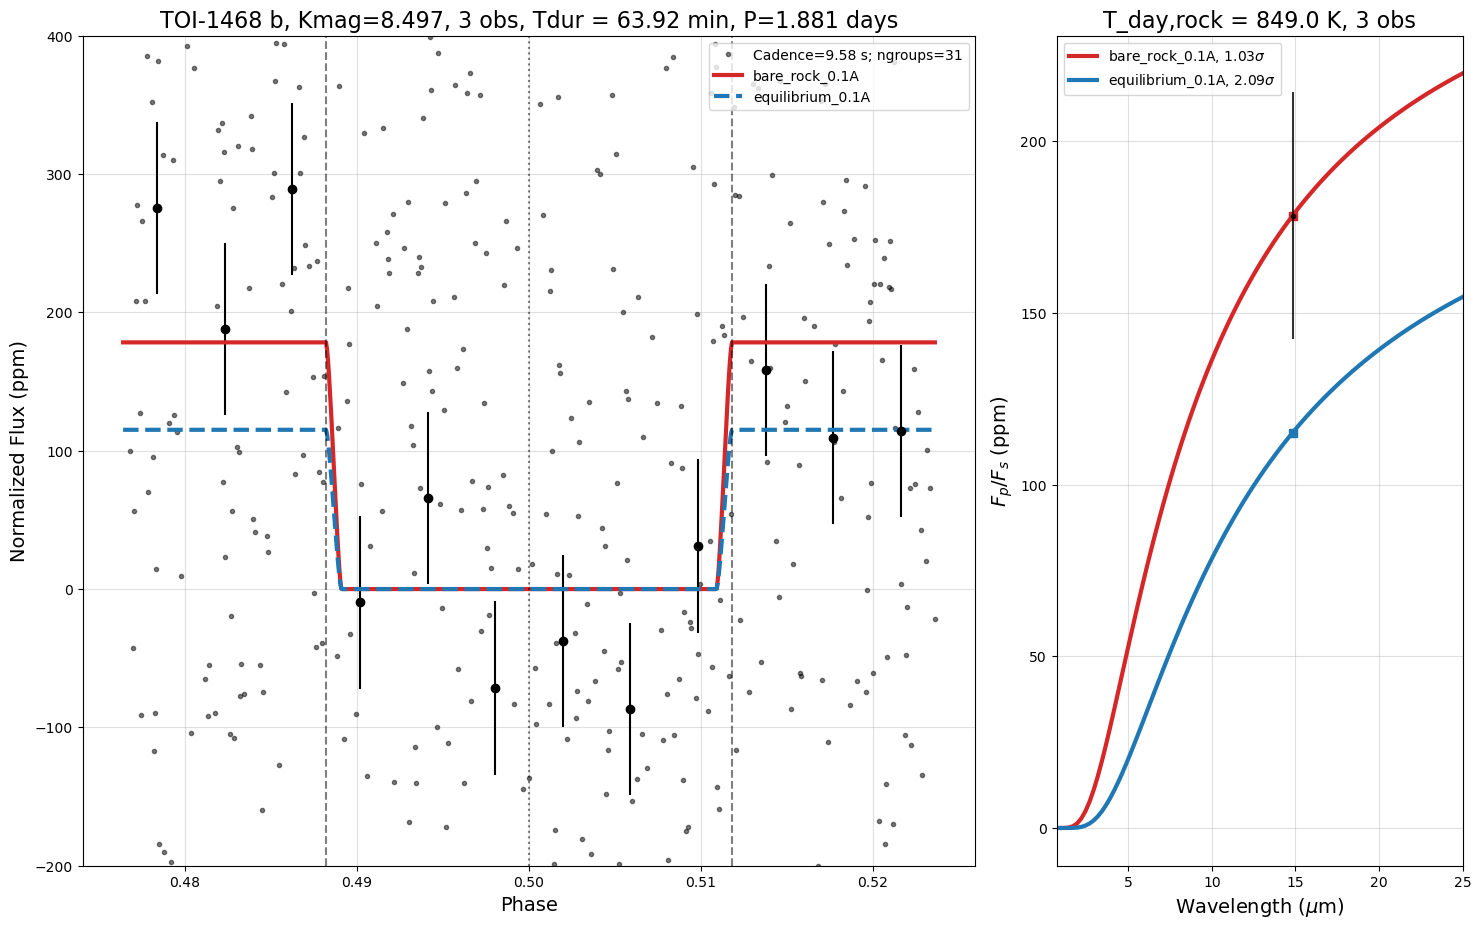

In [93]:
targ = sample[7]
starname = targ['hostname'].replace(' ', '')
input_spec_path = f'{stellar_spec_directory}{starname}_SPHINX_spec.dat'
input_spec = ascii.read(input_spec_path)
input_spec = np.array([input_spec['wave(um)'], input_spec['fluxden(mJy)']])

timing = get_target_timing(targ, filter=targ['filter'], subarray=targ['subarray'], nobs=targ['nobs'], 
                           frac_fullwell=targ['frac_fullwell'], tfrac=1,
                           find_best_subarray=False,
                           stellar_spec='input', input_spec=input_spec,
                           verbose=True)

targ['ngroups'] = timing['ngroups']

model_target_obs(targ, timing,
                 Fp_Fs_from_model=False, Albedos=[0.1], 
                 display_figure=True, save_figure=False)

hostname  pl_name  sy_dist    rastr         decstr    sy_kmag  sy_jmag st_mass st_rad st_raderr1 st_raderr2 st_teff st_tefferr1 st_tefferr2 st_logg st_lum    pl_tranmid    pl_tranmiderr1 pl_tranmiderr2 pl_rade pl_radeerr1 pl_radeerr2 pl_bmasse pl_bmasseerr1 pl_bmasseerr2     pl_orbper     pl_orbpererr1   pl_orbpererr2  pl_orbsmax pl_orbsmaxerr1 pl_orbsmaxerr2 pl_orbincl pl_orbeccen pl_orbeccenerr1 pl_orbeccenerr2     pl_ratror      pl_ratdor tran_flag rv_flag      pl_rp_rs             pl_g            pl_teq_a0            pl_s            pl_rho      filter subarray nobs frac_fullwell ngroup ngroups
-------- --------- ------- ------------ ------------- -------- ------- ------- ------ ---------- ---------- ------- ----------- ----------- ------- ------ ---------------- -------------- -------------- ------- ----------- ----------- --------- ------------- ------------- ----------------- -------------- --------------- ---------- -------------- -------------- ---------- ----------- ----------

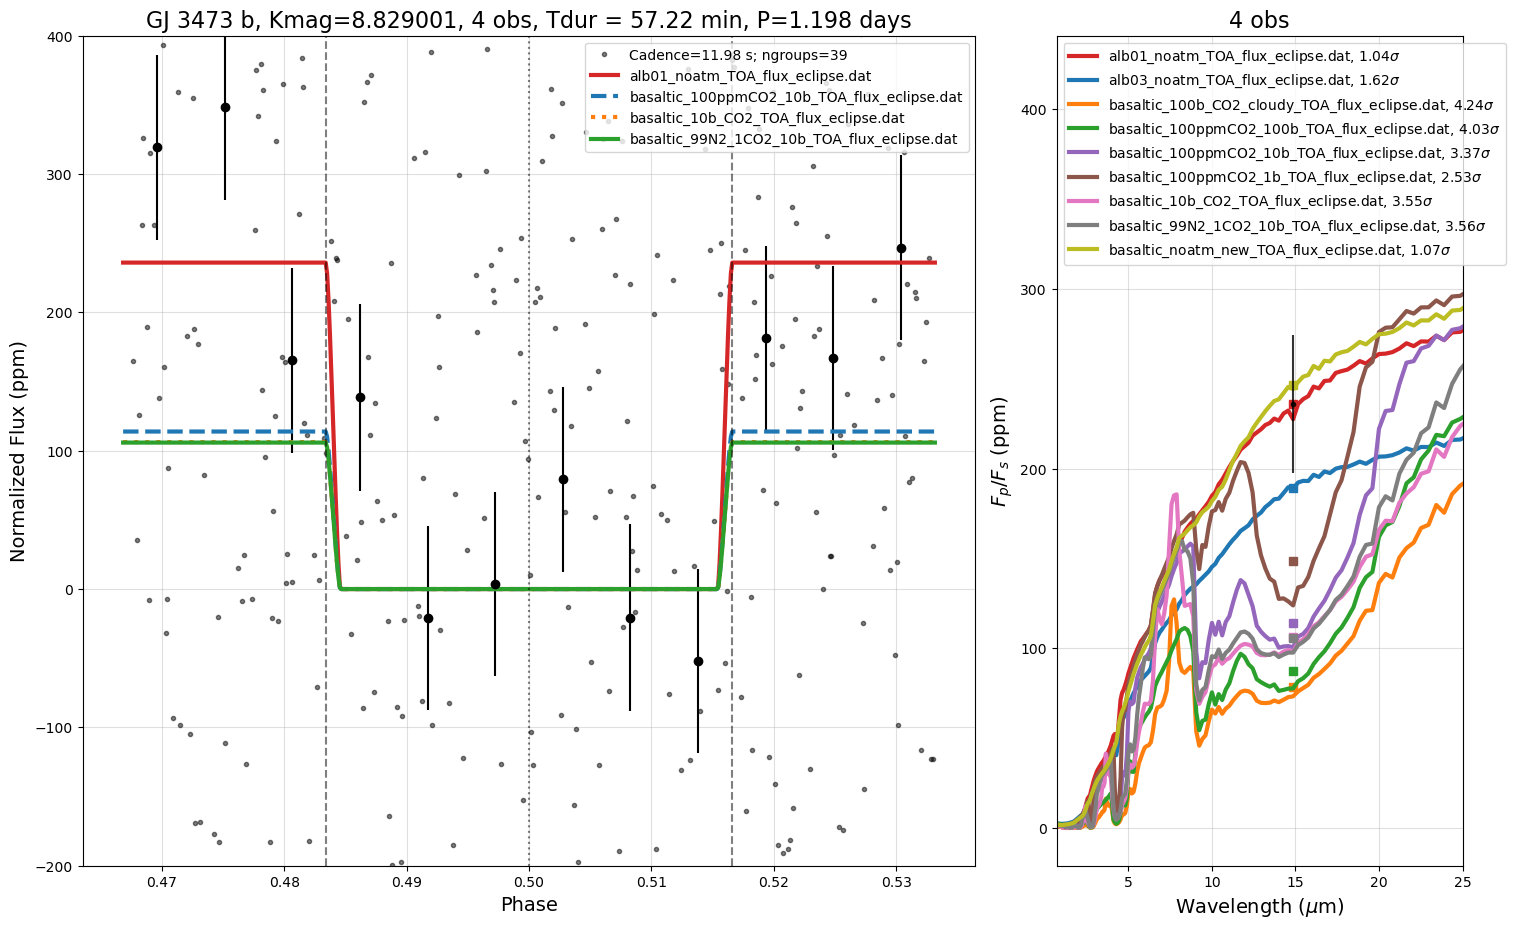

hostname pl_name  sy_dist    rastr         decstr    sy_kmag sy_jmag st_mass st_rad st_raderr1 st_raderr2 st_teff st_tefferr1 st_tefferr2 st_logg st_lum     pl_tranmid    pl_tranmiderr1 pl_tranmiderr2 pl_rade pl_radeerr1 pl_radeerr2 pl_bmasse pl_bmasseerr1 pl_bmasseerr2     pl_orbper      pl_orbpererr1   pl_orbpererr2  pl_orbsmax pl_orbsmaxerr1 pl_orbsmaxerr2 pl_orbincl pl_orbeccen pl_orbeccenerr1 pl_orbeccenerr2      pl_ratror       pl_ratdor tran_flag rv_flag       pl_rp_rs              pl_g            pl_teq_a0            pl_s              pl_rho      filter subarray nobs frac_fullwell ngroup ngroups
-------- -------- ------- ------------ ------------- ------- ------- ------- ------ ---------- ---------- ------- ----------- ----------- ------- ------ ----------------- -------------- -------------- ------- ----------- ----------- --------- ------------- ------------- ------------------ -------------- --------------- ---------- -------------- -------------- ---------- ----------- ----

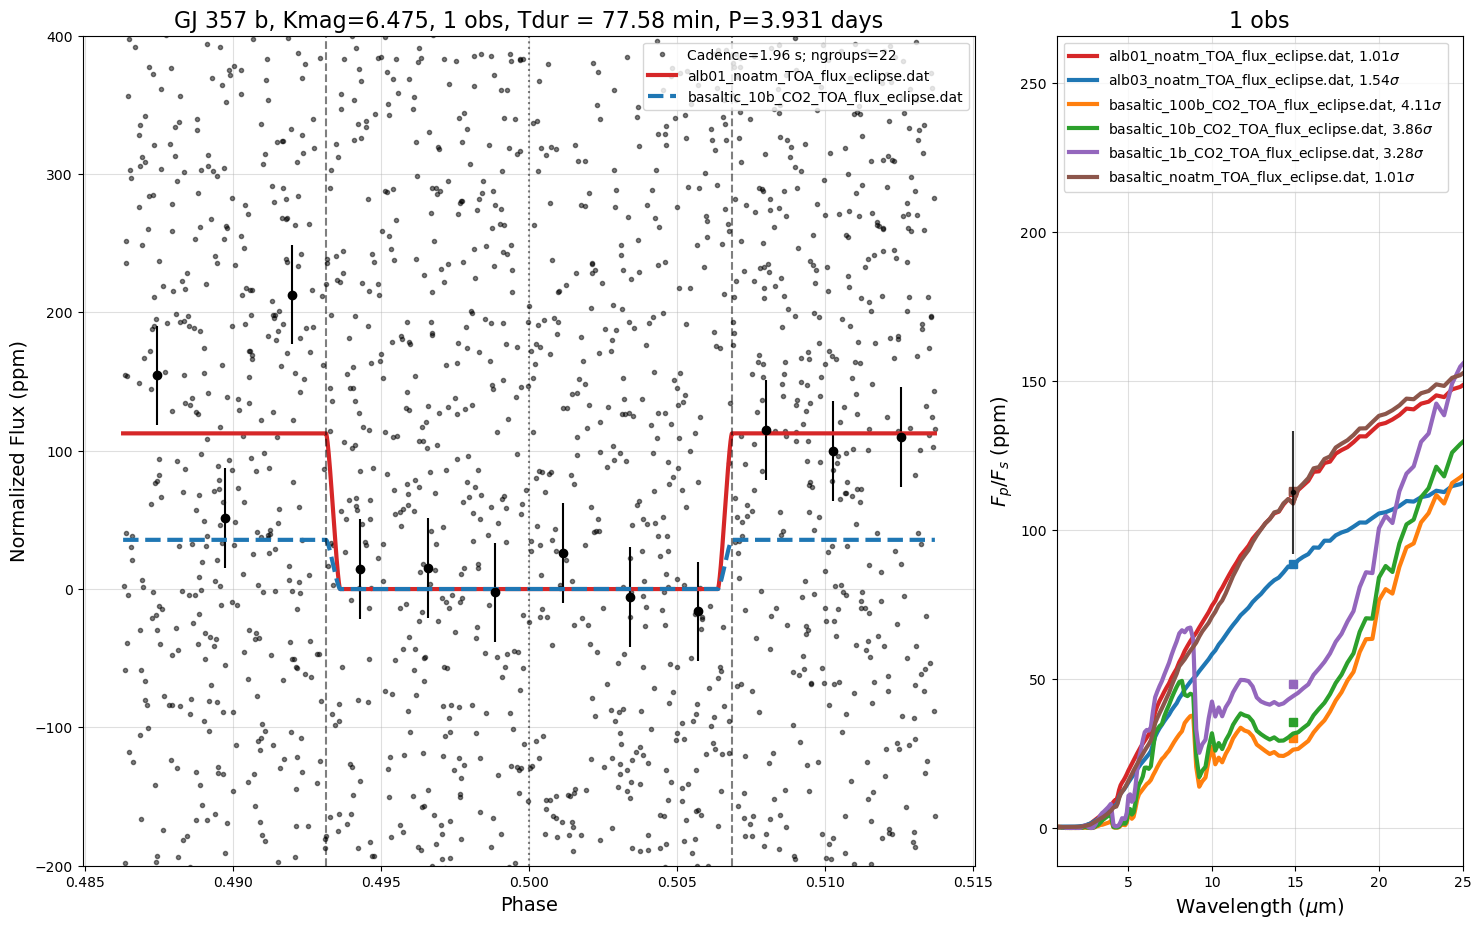

 hostname   pl_name   sy_dist    rastr         decstr    sy_kmag sy_jmag st_mass st_rad st_raderr1 st_raderr2 st_teff st_tefferr1 st_tefferr2 st_logg st_lum  pl_tranmid  pl_tranmiderr1 pl_tranmiderr2 pl_rade pl_radeerr1 pl_radeerr2 pl_bmasse pl_bmasseerr1 pl_bmasseerr2 pl_orbper pl_orbpererr1 pl_orbpererr2 pl_orbsmax pl_orbsmaxerr1 pl_orbsmaxerr2 pl_orbincl pl_orbeccen pl_orbeccenerr1 pl_orbeccenerr2      pl_ratror      pl_ratdor tran_flag rv_flag       pl_rp_rs             pl_g           pl_teq_a0            pl_s              pl_rho      filter subarray nobs frac_fullwell ngroup ngroups
--------- ----------- ------- ------------ ------------- ------- ------- ------- ------ ---------- ---------- ------- ----------- ----------- ------- ------ ------------ -------------- -------------- ------- ----------- ----------- --------- ------------- ------------- --------- ------------- ------------- ---------- -------------- -------------- ---------- ----------- --------------- --------------- -

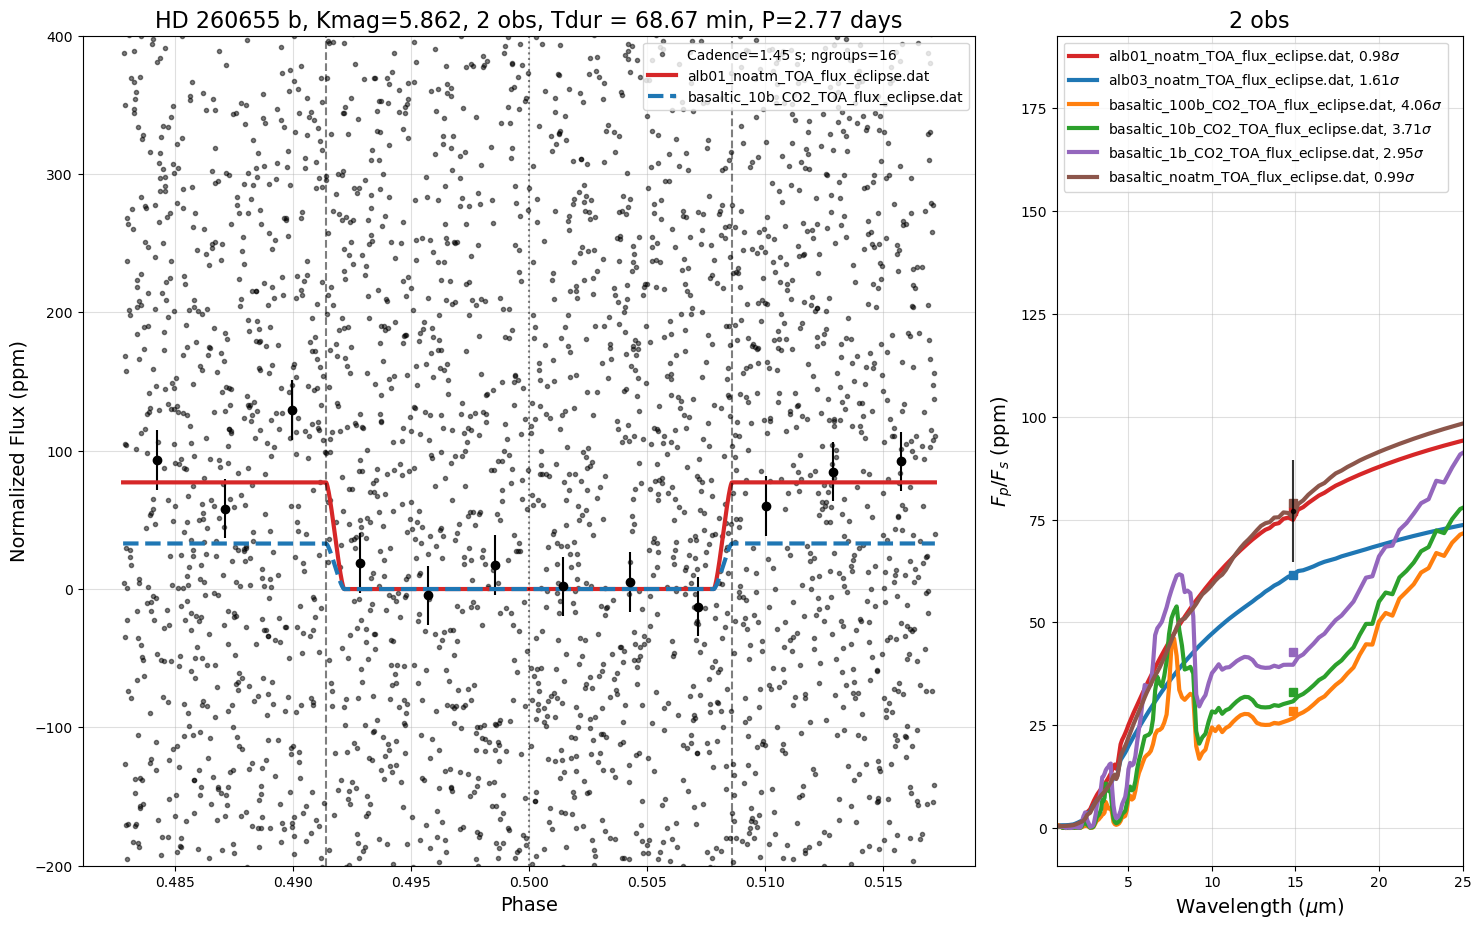

hostname  pl_name  sy_dist    rastr         decstr    sy_kmag sy_jmag st_mass st_rad st_raderr1 st_raderr2 st_teff st_tefferr1 st_tefferr2 st_logg st_lum  pl_tranmid  pl_tranmiderr1 pl_tranmiderr2 pl_rade pl_radeerr1 pl_radeerr2 pl_bmasse pl_bmasseerr1 pl_bmasseerr2 pl_orbper pl_orbpererr1 pl_orbpererr2 pl_orbsmax pl_orbsmaxerr1 pl_orbsmaxerr2 pl_orbincl pl_orbeccen pl_orbeccenerr1 pl_orbeccenerr2     pl_ratror      pl_ratdor tran_flag rv_flag      pl_rp_rs             pl_g           pl_teq_a0             pl_s              pl_rho       filter subarray nobs frac_fullwell ngroup ngroups
-------- --------- ------- ------------ ------------- ------- ------- ------- ------ ---------- ---------- ------- ----------- ----------- ------- ------ ------------ -------------- -------------- ------- ----------- ----------- --------- ------------- ------------- --------- ------------- ------------- ---------- -------------- -------------- ---------- ----------- --------------- --------------- -------

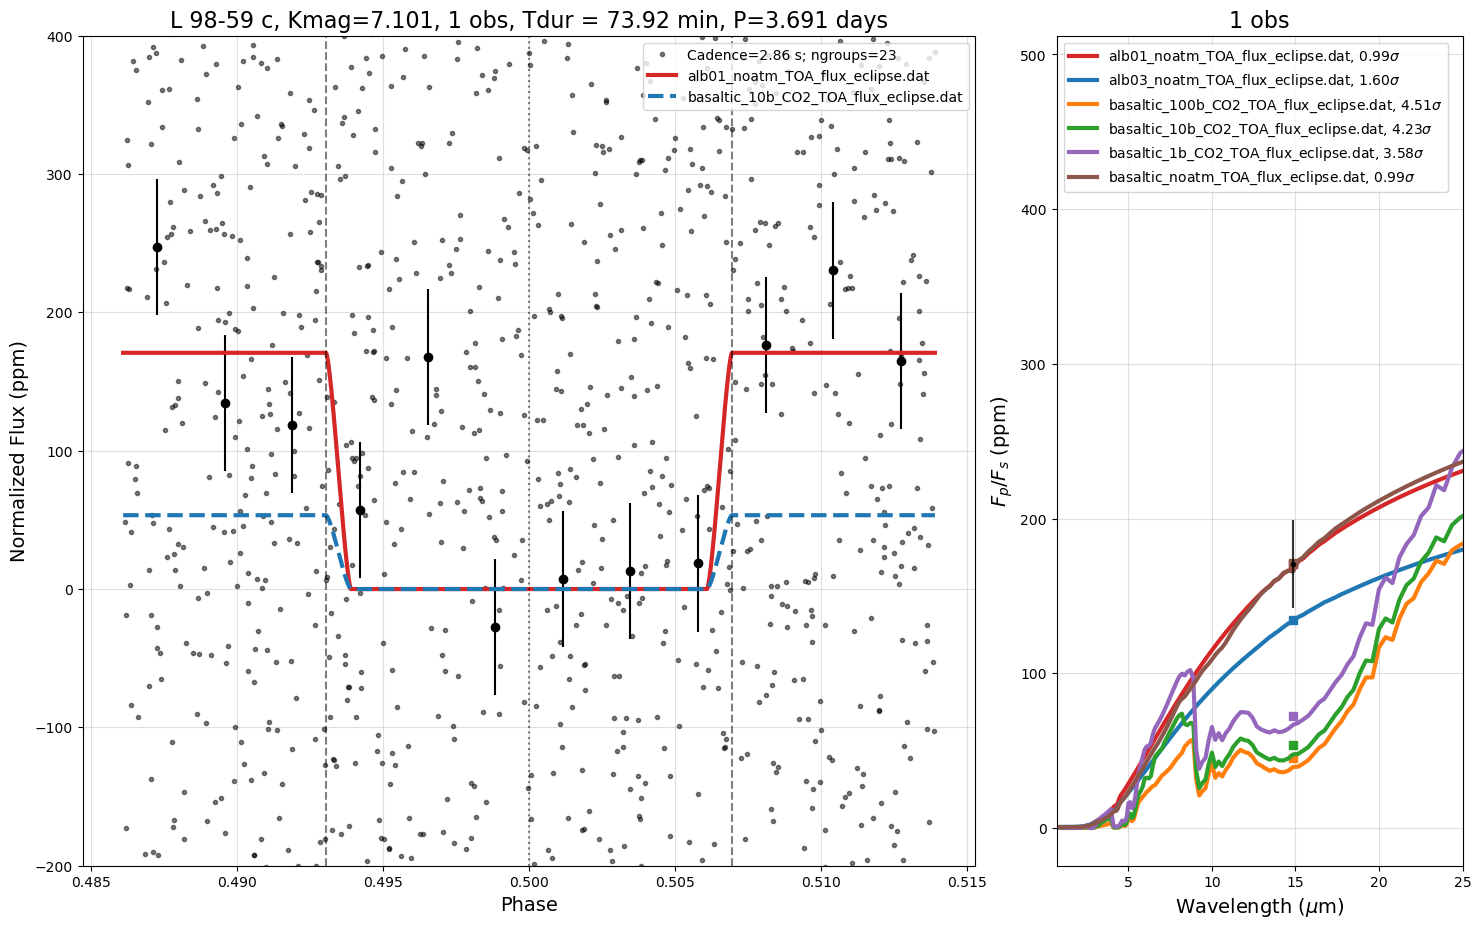

hostname  pl_name   sy_dist    rastr         decstr    sy_kmag sy_jmag  st_mass st_rad st_raderr1 st_raderr2 st_teff st_tefferr1 st_tefferr2 st_logg st_lum    pl_tranmid   pl_tranmiderr1 pl_tranmiderr2 pl_rade pl_radeerr1 pl_radeerr2 pl_bmasse pl_bmasseerr1 pl_bmasseerr2  pl_orbper  pl_orbpererr1   pl_orbpererr2  pl_orbsmax pl_orbsmaxerr1 pl_orbsmaxerr2 pl_orbincl pl_orbeccen pl_orbeccenerr1 pl_orbeccenerr2      pl_ratror      pl_ratdor tran_flag rv_flag       pl_rp_rs             pl_g            pl_teq_a0             pl_s             pl_rho      filter subarray nobs frac_fullwell ngroup ngroups
-------- ---------- ------- ------------ ------------- ------- -------- ------- ------ ---------- ---------- ------- ----------- ----------- ------- ------ --------------- -------------- -------------- ------- ----------- ----------- --------- ------------- ------------- ----------- -------------- --------------- ---------- -------------- -------------- ---------- ----------- --------------- --

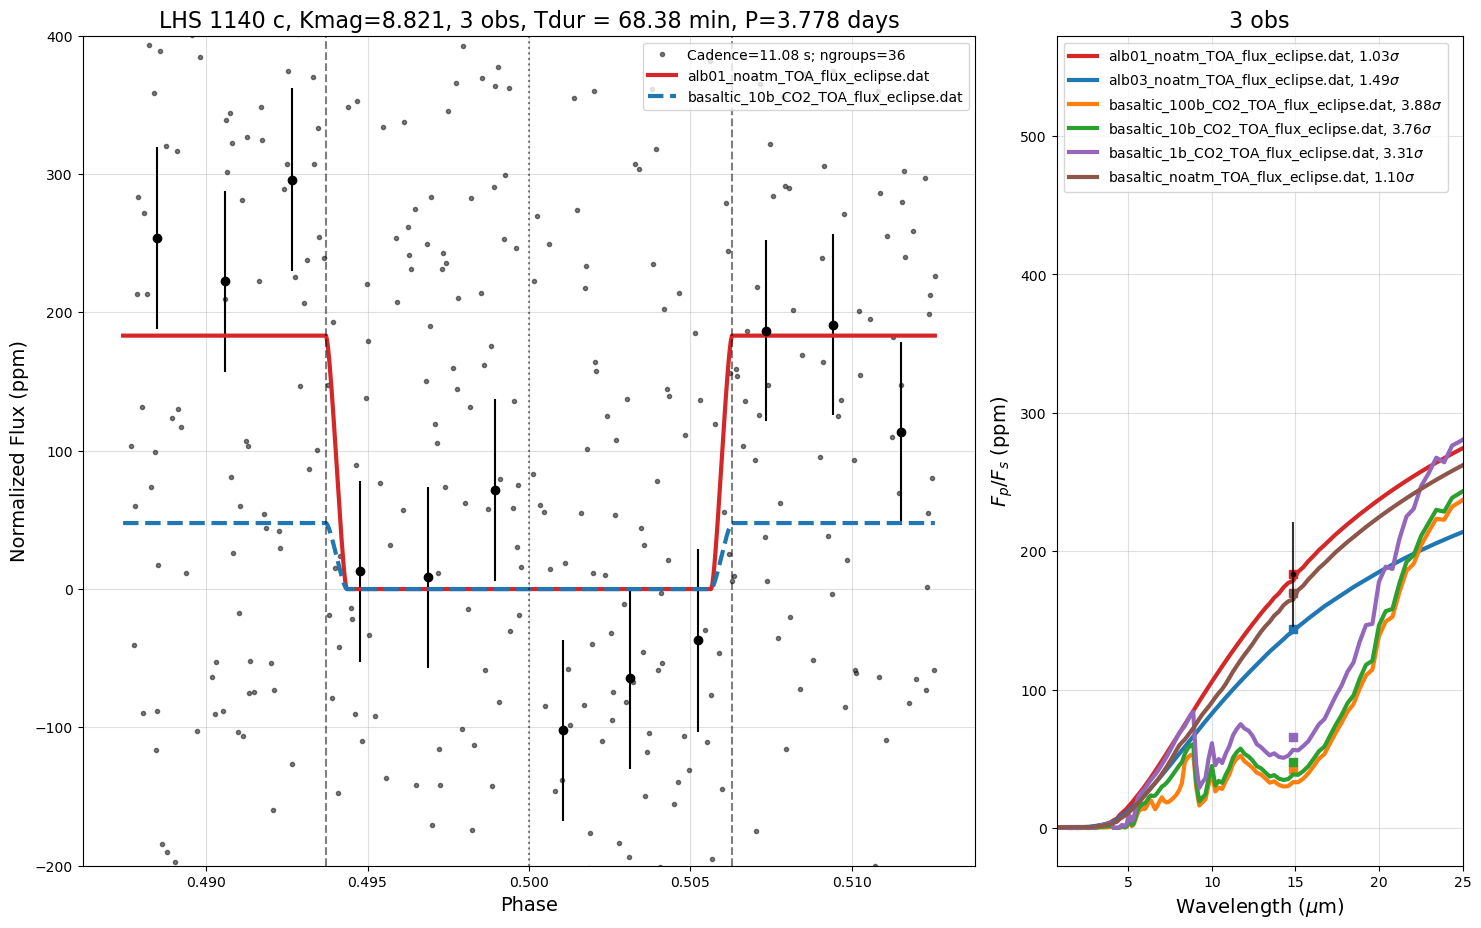

hostname  pl_name   sy_dist    rastr         decstr    sy_kmag sy_jmag st_mass st_rad st_raderr1 st_raderr2 st_teff st_tefferr1 st_tefferr2 st_logg st_lum   pl_tranmid  pl_tranmiderr1 pl_tranmiderr2 pl_rade pl_radeerr1 pl_radeerr2 pl_bmasse pl_bmasseerr1 pl_bmasseerr2 pl_orbper pl_orbpererr1 pl_orbpererr2 pl_orbsmax pl_orbsmaxerr1 pl_orbsmaxerr2 pl_orbincl pl_orbeccen pl_orbeccenerr1 pl_orbeccenerr2      pl_ratror       pl_ratdor tran_flag rv_flag       pl_rp_rs              pl_g            pl_teq_a0            pl_s              pl_rho      filter subarray nobs frac_fullwell ngroup ngroups
-------- ---------- ------- ------------ ------------- ------- ------- ------- ------ ---------- ---------- ------- ----------- ----------- ------- ------ ------------- -------------- -------------- ------- ----------- ----------- --------- ------------- ------------- --------- ------------- ------------- ---------- -------------- -------------- ---------- ----------- --------------- --------------- 

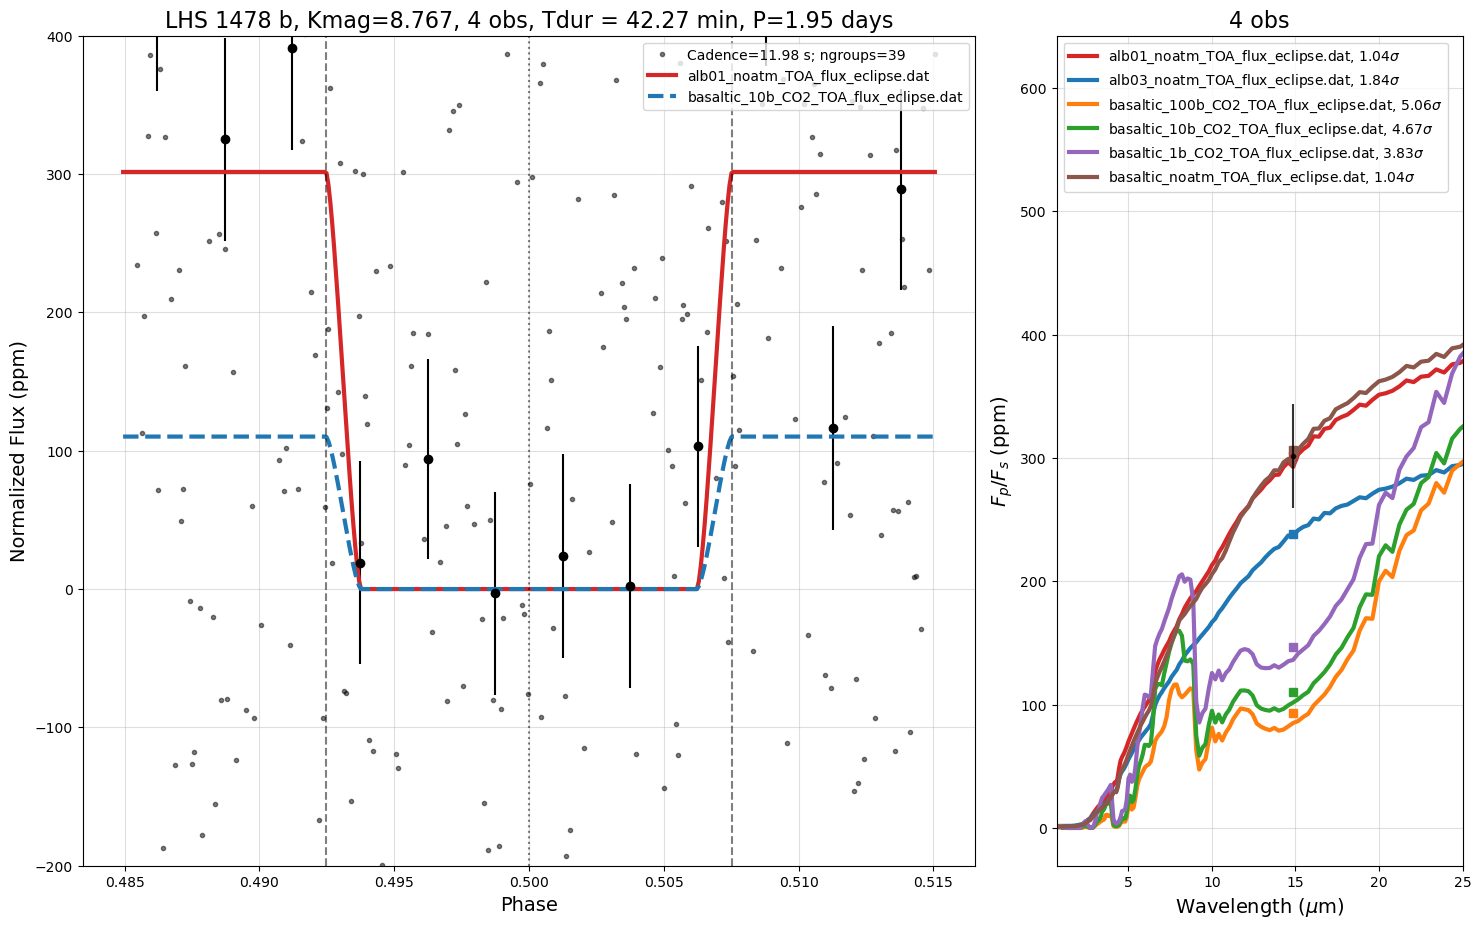

hostname  pl_name   sy_dist    rastr         decstr    sy_kmag  sy_jmag st_mass st_rad st_raderr1 st_raderr2 st_teff st_tefferr1 st_tefferr2 st_logg st_lum   pl_tranmid  pl_tranmiderr1 pl_tranmiderr2 pl_rade pl_radeerr1 pl_radeerr2 pl_bmasse pl_bmasseerr1 pl_bmasseerr2 pl_orbper pl_orbpererr1 pl_orbpererr2 pl_orbsmax pl_orbsmaxerr1 pl_orbsmaxerr2 pl_orbincl pl_orbeccen pl_orbeccenerr1 pl_orbeccenerr2      pl_ratror       pl_ratdor tran_flag rv_flag       pl_rp_rs              pl_g           pl_teq_a0            pl_s              pl_rho      filter subarray nobs frac_fullwell ngroup ngroups
-------- ---------- ------- ------------ ------------- -------- ------- ------- ------ ---------- ---------- ------- ----------- ----------- ------- ------ ------------- -------------- -------------- ------- ----------- ----------- --------- ------------- ------------- --------- ------------- ------------- ---------- -------------- -------------- ---------- ----------- --------------- ---------------

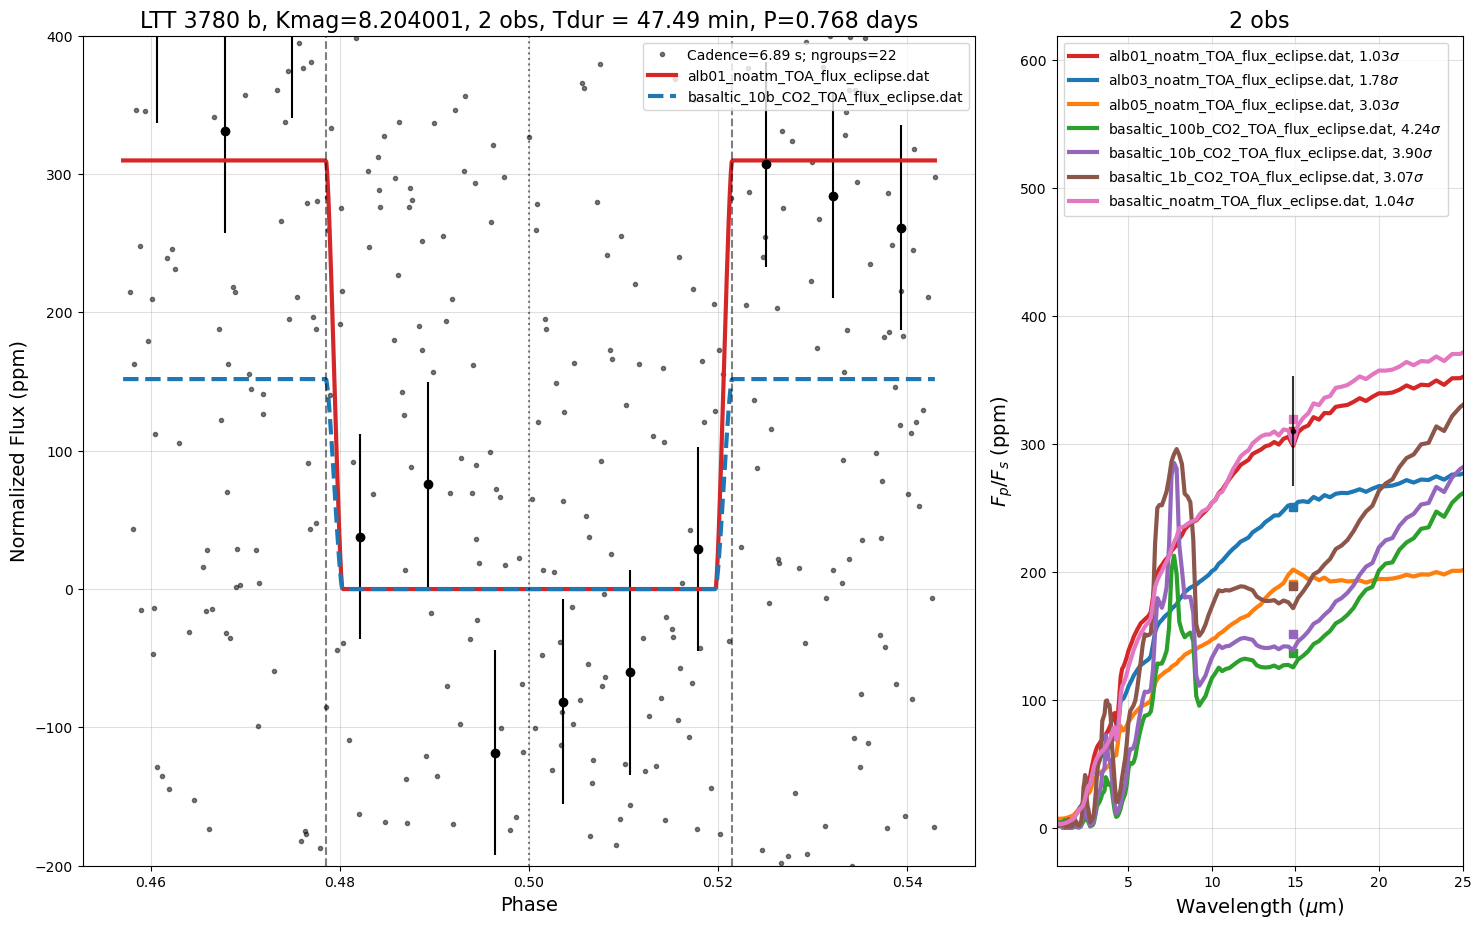

hostname  pl_name   sy_dist    rastr         decstr    sy_kmag sy_jmag st_mass st_rad st_raderr1 st_raderr2 st_teff st_tefferr1 st_tefferr2 st_logg st_lum   pl_tranmid  pl_tranmiderr1 pl_tranmiderr2 pl_rade pl_radeerr1 pl_radeerr2 pl_bmasse pl_bmasseerr1 pl_bmasseerr2 pl_orbper pl_orbpererr1 pl_orbpererr2 pl_orbsmax pl_orbsmaxerr1 pl_orbsmaxerr2 pl_orbincl pl_orbeccen pl_orbeccenerr1 pl_orbeccenerr2      pl_ratror      pl_ratdor tran_flag rv_flag       pl_rp_rs             pl_g            pl_teq_a0            pl_s             pl_rho      filter subarray nobs frac_fullwell ngroup ngroups
-------- ---------- ------- ------------ ------------- ------- ------- ------- ------ ---------- ---------- ------- ----------- ----------- ------- ------ ------------- -------------- -------------- ------- ----------- ----------- --------- ------------- ------------- --------- ------------- ------------- ---------- -------------- -------------- ---------- ----------- --------------- --------------- ---

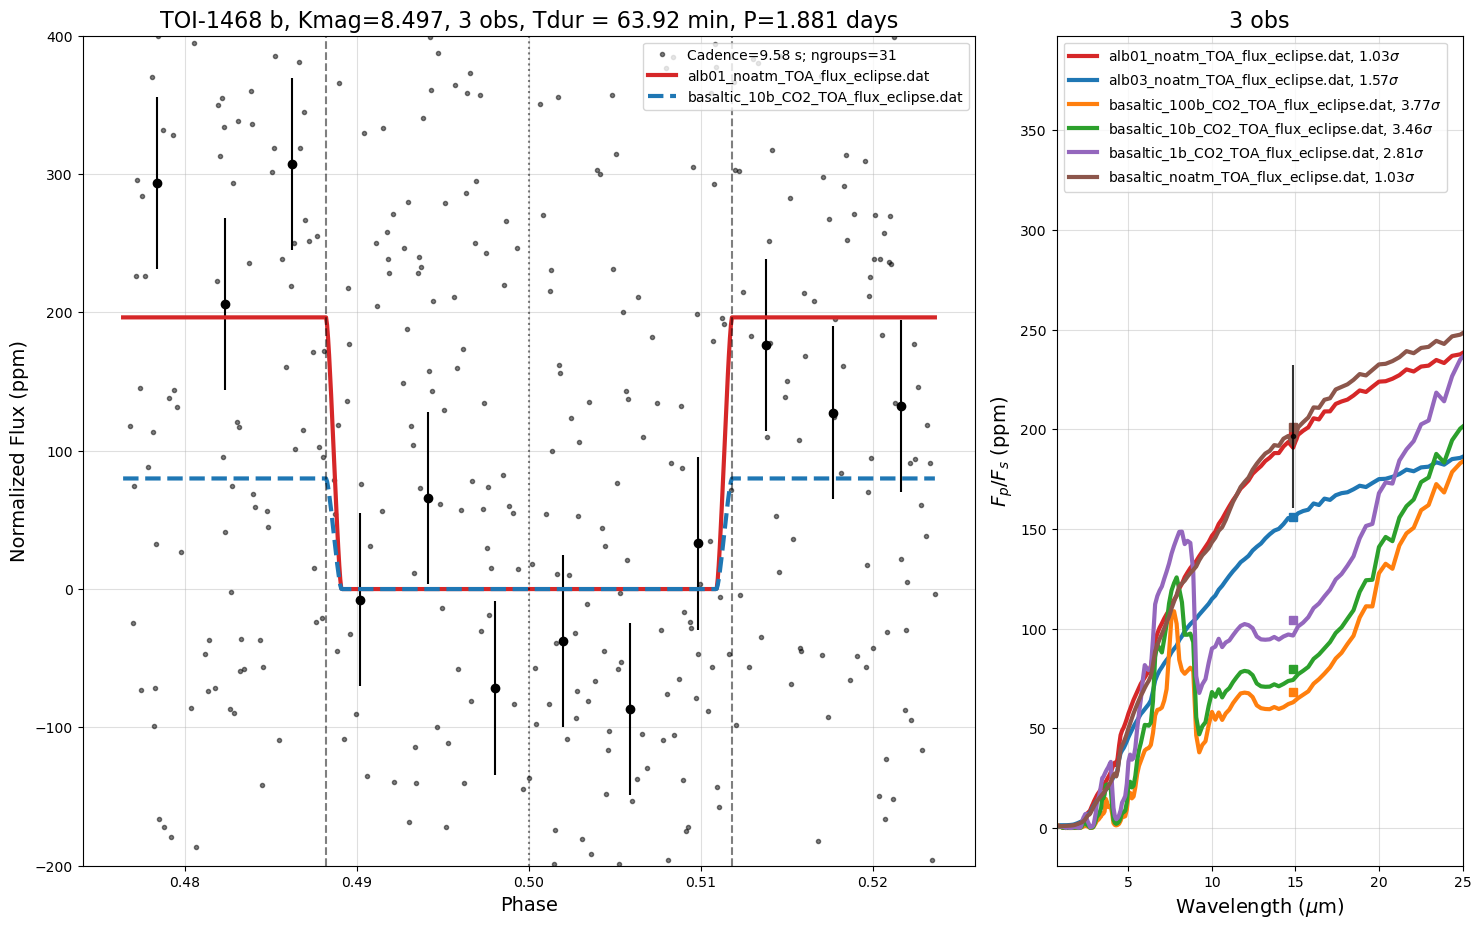

hostname  pl_name  sy_dist    rastr         decstr    sy_kmag sy_jmag st_mass st_rad st_raderr1 st_raderr2 st_teff st_tefferr1 st_tefferr2 st_logg st_lum   pl_tranmid  pl_tranmiderr1 pl_tranmiderr2 pl_rade pl_radeerr1 pl_radeerr2 pl_bmasse pl_bmasseerr1 pl_bmasseerr2 pl_orbper pl_orbpererr1 pl_orbpererr2 pl_orbsmax pl_orbsmaxerr1 pl_orbsmaxerr2 pl_orbincl pl_orbeccen pl_orbeccenerr1 pl_orbeccenerr2      pl_ratror       pl_ratdor tran_flag rv_flag       pl_rp_rs              pl_g           pl_teq_a0            pl_s              pl_rho      filter subarray nobs frac_fullwell ngroup ngroups
-------- --------- ------- ------------ ------------- ------- ------- ------- ------ ---------- ---------- ------- ----------- ----------- ------- ------ ------------- -------------- -------------- ------- ----------- ----------- --------- ------------- ------------- --------- ------------- ------------- ---------- -------------- -------------- ---------- ----------- --------------- --------------- ---

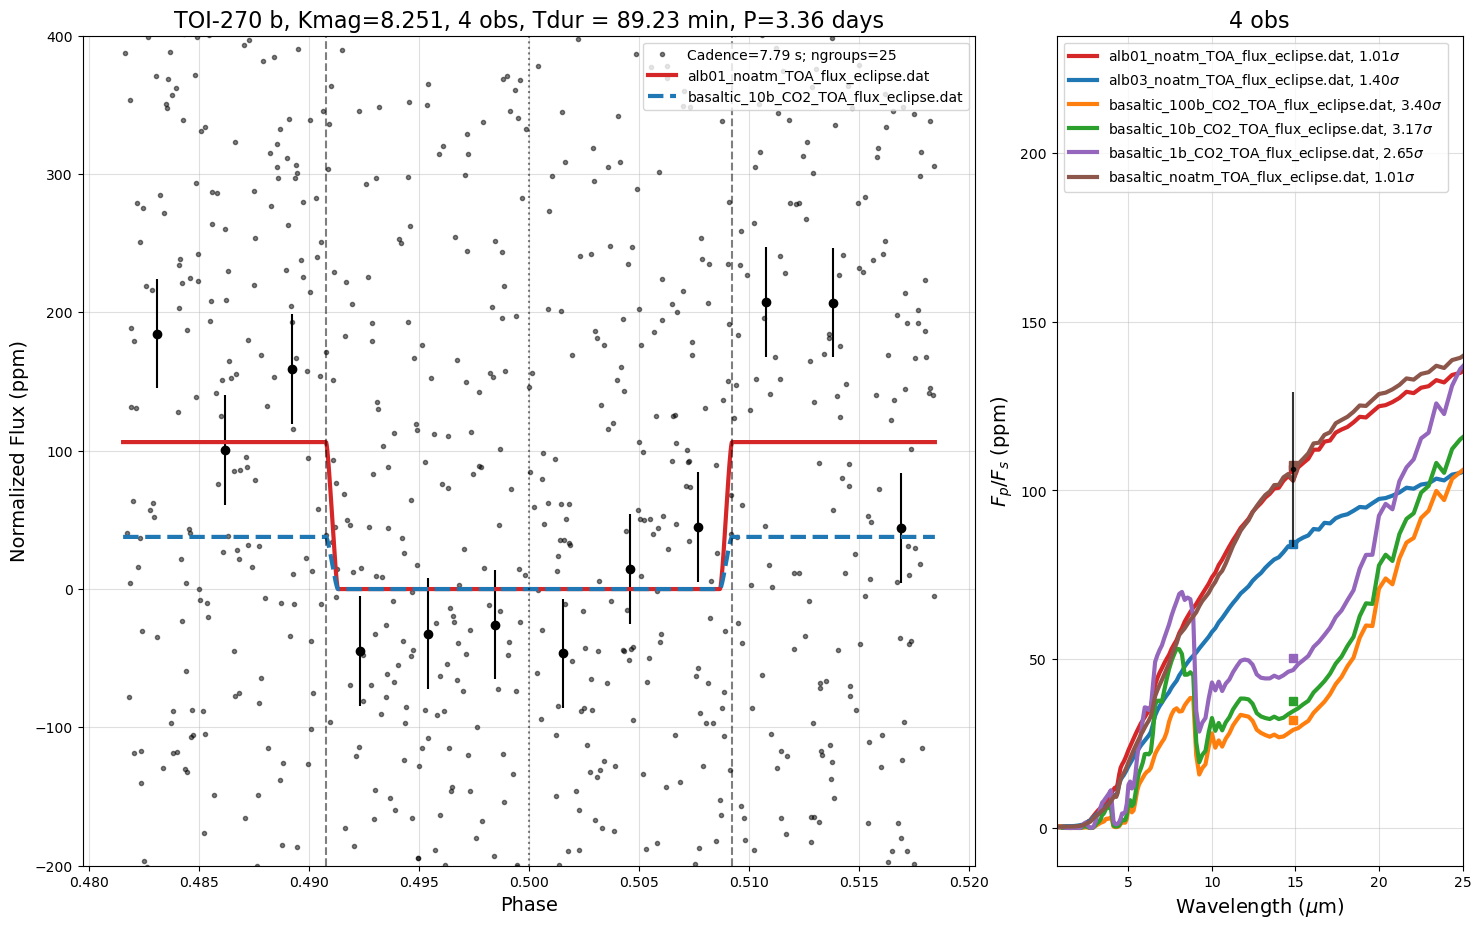

In [94]:
%matplotlib inline
for targ in sample:
    starname = targ['hostname'].replace(' ', '')
    input_spec_path = f'{stellar_spec_directory}{starname}_SPHINX_spec.dat'
    input_spec = ascii.read(input_spec_path)
    input_spec = np.array([input_spec['wave(um)'], input_spec['fluxden(mJy)']])
    
    timing = get_target_timing(targ, filter=targ['filter'], subarray=targ['subarray'], nobs=targ['nobs'], 
                               frac_fullwell=targ['frac_fullwell'], tfrac=1,
                               find_best_subarray=False,
                               stellar_spec='input', input_spec=input_spec,
                               verbose=True)
    
    targ['ngroups'] = timing['ngroups']
    
    model_target_obs(targ, timing,
                     Fp_Fs_from_model=True, Albedos=[], 
                     display_figure=True, save_figure=False)

In [95]:
ascii.write(sample, 'sample_final.csv', overwrite=True)

In [96]:
sample['hostname', 'pl_name', 'subarray', 'ngroups', 'frac_fullwell']

hostname,pl_name,subarray,ngroups,frac_fullwell
str9,str11,str6,int64,float64
GJ 3473,GJ 3473 b,sub256,39,0.65
GJ 357,GJ 357 b,sub64,22,0.85
HD 260655,HD 260655 b,sub64,16,0.95
L 98-59,L 98-59 c,sub128,23,0.7
LHS 1140,LHS 1140 c,sub256,36,0.65
LHS 1478,LHS 1478 b,sub256,39,0.65
LTT 3780,LTT 3780 b,sub256,22,0.65
TOI-1468,TOI-1468 b,sub256,31,0.65
TOI-270,TOI-270 b,sub256,25,0.65
